In [1]:
from tools.providers import WiktionaryProvider
from tools.dumps import download_to

WiktionaryProvider.dump_full_dataset(revision="20200701")

https://dumps.wikimedia.org/enwiktionary/20200701/wiktionary/enwiktionary-20200701-pages-articles.xml.bz2


HTTPError: HTTP Error 404: Not Found

In [1]:
import os
os.environ['SPARK_OPTS'] = '--driver-java-options=-Xms1024M --driver-java-options=-Xmx12G --driver-java-options=-Dlog4j.logLevel=info'

## notes on wiktextract

It seems the maintainer is still working on the library but the latest package version in PyPI is fairly old (2018), but still works good.

I used the CLI to dump the wiktionary dump.

TODO: process it into a faster index-based data format.

In [2]:
import os

from pyspark import SparkContext
from pyspark.sql import SparkSession

parquet_pos = os.path.join(os.getcwd(), "data/wiktionary/parquet-index_2.11-0.4.1-SNAPSHOT.jar")

spark = SparkSession.builder \
                        .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
                        .config("spark.jars", parquet_pos) \
                        .getOrCreate()

spark.sparkContext.addPyFile(parquet_pos)
#spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

In [3]:
wiktionary_df = spark.read.json("data/wiktionary/wikt.words")

In [4]:
wiktionary_df.printSchema()

root
 |-- abbreviations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- sense: string (nullable = true)
 |    |    |-- word: string (nullable = true)
 |-- alternate: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- antonyms: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- sense: string (nullable = true)
 |    |    |-- word: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- compounds: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- word: string (nullable = true)
 |-- conjugation: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- 1: string (nullable = true)
 |    |    |-- 2: string (nullable = true)
 |    |    |-- 3: string (nullable = true)
 |    |    |-- 4: string (nullable = true)
 |    |    |-- 5: string (nullable = true)
 |    |    |--

### Wiktionary parsed dump format (English only)

- word: a grammatical form, mainly a lexeme
- translations: an array of Elements. Each translation Element contains:
    - roman: roman transcript (for non-latin-alphabet languages)
    - script: original transcript
    - sense: the sense of the proposed translation
    - tags: a list of strings???
    - word: the proposed translation word.
- synonyms: ...

In [5]:
example_rows = wiktionary_df.limit(100).collect()

In [6]:
from pyspark.sql.functions import explode, flatten

wiktionary_df.select(["word", explode("senses")]).printSchema()

root
 |-- word: string (nullable = true)
 |-- col: struct (nullable = true)
 |    |-- agent_of: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- alt_of: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- color: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- complex_inflection_of: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- 1: string (nullable = true)
 |    |    |    |-- 10: string (nullable = true)
 |    |    |    |-- 11: string (nullable = true)
 |    |    |    |-- 12: string (nullable = true)
 |    |    |    |-- 13: string (nullable = true)
 |    |    |    |-- 14: string (nullable = true)
 |    |    |    |-- 2: string (nullable = true)
 |    |    |    |-- 3: string (nullable = true)
 |    |    |    |-- 4: string (nullable = true)
 |    |    |    |-- 5: string (nullable = true)
 |    |    |    |-- 6: string (nullable = t

In [134]:
def sample(n, df=wiktionary_df):
    return df.sample(False, 10 / df.count(), seed=42)

In [135]:
sample_10 = sample(10).collect()

In [5]:
from pyspark.sql.functions import *

def count_distinct_pos(df):
    df.select('pos').groupBy('pos').count().show(n=30)

count_distinct_pos(wiktionary_df)

+-----------+------+
|        pos| count|
+-----------+------+
|       conj|   295|
|     abbrev|   701|
|        det|   233|
|  circumfix|     3|
|       name| 93961|
|       prep|   657|
|     suffix|   867|
|      postp|     7|
|      punct|    23|
|       null| 50658|
|       pron|   695|
|      infix|    47|
|     letter|    57|
|     symbol|   189|
|   particle|    50|
|        num|   367|
|     phrase|  2837|
|        adj|140361|
|    article|    20|
|        adv| 21450|
|prep_phrase|  1990|
|   interfix|     8|
|    proverb|  1067|
|       verb|142890|
|       intj|  3144|
|       noun|587509|
| participle|     4|
|      affix|     4|
+-----------+------+



In [10]:
def print_pos_category(df, pos):
    print("Results for pos " + pos)
    df.select("word").where(df.pos == pos).show()

print_pos_category(wiktionary_df, "affix")
print_pos_category(wiktionary_df, "participle")
print_pos_category(wiktionary_df, "interfix")
print_pos_category(wiktionary_df, "article")

Results for pos affix
+-----+
| word|
+-----+
| -un-|
|  -o-|
|-vir-|
|-kin-|
+-----+

Results for pos participle
+-------+
|   word|
+-------+
|   bawn|
|   yfed|
|welting|
|   cit.|
+-------+

Results for pos interfix
+----+
|word|
+----+
| -o-|
| -i-|
| -i-|
| -s-|
| -k-|
| -n-|
| -a-|
| -v-|
+----+

Results for pos article
+---------------+
|           word|
+---------------+
|            the|
|             de|
|             an|
|              ⠁|
|             ye|
|             da|
|            zee|
|             le|
|             za|
|            teh|
|             t'|
|            tho|
|             ze|
|              a|
|            hoi|
|           thay|
|           a(n)|
|             𐑞|
|            t3h|
|an/translations|
+---------------+



In [11]:
sample_10 = wiktionary_df.select([explode("senses").alias("sense")]) \
             .groupBy("sense.color") \
             .count()

In [12]:
sample_10.show()

+---------+-------+
|    color|  count|
+---------+-------+
| [9D8085]|      1|
| [yellow]|      1|
|     null|1177684|
|[#1E90FF]|      1|
| [88c641]|      2|
| [E3D733]|      1|
| [4C2F27]|      1|
| [E82D14]|      1|
| [1d5868]|      1|
+---------+-------+



In [13]:
wiktionary_df.select('categories').where(wiktionary_df['word'] == 'ran').show(truncate=False)

+-------------------------------------+
|categories                           |
+-------------------------------------+
|null                                 |
|null                                 |
|[English irregular simple past forms]|
+-------------------------------------+



In [14]:
wiktionary_df.select('categories').where(wiktionary_df['word'] == 'run').show(truncate=False)

+---------------------------------------------------+
|categories                                         |
+---------------------------------------------------+
|null                                               |
|null                                               |
|null                                               |
|[English basic words, English class 3 strong verbs]|
+---------------------------------------------------+



In [15]:
categories = wiktionary_df.select(explode('categories').alias("cat")).where('cat like "English%"').distinct().sort('cat').collect()

In [16]:
categories

[Row(cat='English'),
 Row(cat='English 1-syllable words'),
 Row(cat='English 10-syllable words'),
 Row(cat='English 11-syllable words'),
 Row(cat='English 12-syllable words'),
 Row(cat='English 13-syllable words'),
 Row(cat='English 14-syllable words'),
 Row(cat='English 15-syllable words'),
 Row(cat='English 2-syllable words'),
 Row(cat='English 2-syllable words\u200e'),
 Row(cat='English 3-syllable words'),
 Row(cat='English 3-syllable words\u200e'),
 Row(cat='English 4-syllable words'),
 Row(cat='English 4chan slang'),
 Row(cat='English 4chan slang\u200e'),
 Row(cat='English 5-syllable words'),
 Row(cat='English 6-syllable words'),
 Row(cat='English 6-syllable words\u200e'),
 Row(cat='English 7-syllable words'),
 Row(cat='English 8-syllable words'),
 Row(cat='English Braille abbreviations'),
 Row(cat='English Braille arithmetical symbols'),
 Row(cat='English Braille contractions'),
 Row(cat='English Braille letters'),
 Row(cat='English Braille punctuation'),
 Row(cat='English Braill

In [17]:
len(categories)

1381

In [18]:
most_common_categories = wiktionary_df.select(explode('categories').alias("cat")).where('cat like "English%"').groupBy('cat').count().sort(desc('count'))

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

categories_pdf = most_common_categories.toPandas()

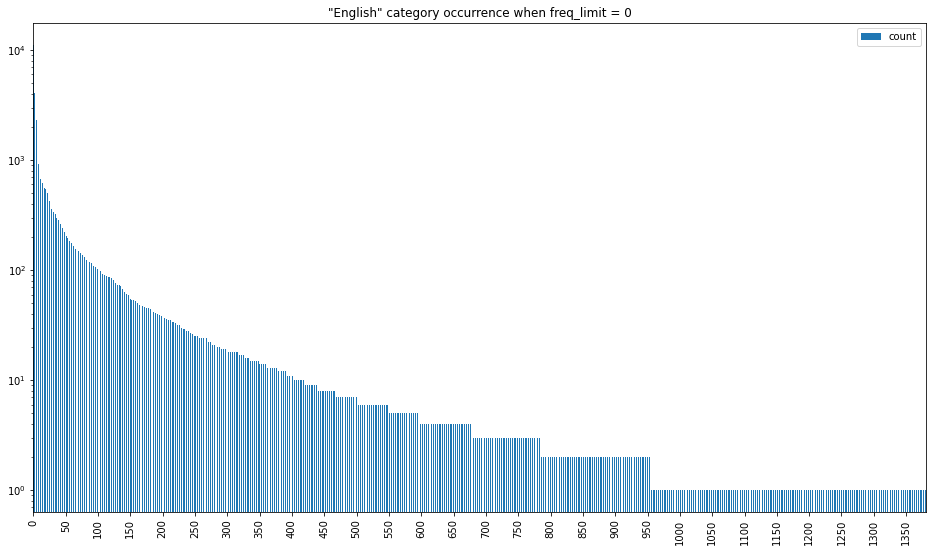

In [20]:
# Forgive me for this horrible plot. 

def plot_limited(categories_pdf, freq_limit=0):
    categories = categories_pdf[categories_pdf['count'] > freq_limit]
    categories.plot(kind='bar', xticks=range(0, len(categories)+1, 50), logy=True,
                                                     figsize=(16, 9), title=f"\"English\" category occurrence when freq_limit = {freq_limit}")

plot_limited(categories_pdf)

## Dump to parquet and indexing

In [22]:
from lightcopy.index import QueryContext

from math import sqrt

def dump(size=0):
    size_str = str(size) if size > 0 else "full"
    dump_name = f"data/wiktionary/sample_{size_str}.parquet"
    
    # Avoid very-long words from being recorded.
    # On many linux file systems htere are limitations on word length. 
    cursor = wiktionary_df.filter(length('word') < 100)
    if size > 0:
        cursor = cursor.sample(size / wiktionary_df.count())
        
    print(f"Dumping onto {dump_name}")
    if size > 0:
        partitions = int(sqrt(size))
    else:
        partitions = 1000
    cursor.repartition(partitions).write.mode('overwrite').save(dump_name)

In [23]:
dump()

Dumping onto data/wiktionary/sample_full.parquet


In [30]:
from lightcopy.index import QueryContext
context = QueryContext(spark)
# Save indices onto the parquet dump, and also as under the "sample_full" alias
context.index.create.mode('overwrite').indexBy("word").parquet("data/wiktionary/sample_full.parquet")

AttributeError: 'NoneType' object has no attribute 'table'

In [25]:
dump(10)
dump(100)
dump(1000)

Dumping onto data/wiktionary/sample_10.parquet
Dumping onto data/wiktionary/sample_100.parquet
Dumping onto data/wiktionary/sample_1000.parquet


In [36]:
wiktionary_indexed_df = context.index.parquet('data/wiktionary/sample_full.parquet')

In [49]:
%%timeit

wiktionary_indexed_df.filter('word == "test"').collect()

2.73 s ± 75.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [46]:
%%timeit

wiktionary_df.filter("word == 'test'").collect()

9.82 s ± 680 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [50]:
wiktionary_df.count()

1050094

In [81]:
# Get a list of irregular verbs

irregular_list = ["run", "eat", "think", "teach", "see"]

for verb in irregular_list:
    categories = wiktionary_df.select(wiktionary_df.word, explode('categories').alias("cat")) \
                                   .where(f'word = "{verb}"') \
                                   .distinct().sort('cat').collect()
    print(verb)
    print(categories)
    print("===========")

run
[Row(word='run', cat='English basic words'), Row(word='run', cat='English class 3 strong verbs')]
eat
[Row(word='eat', cat='English basic words'), Row(word='eat', cat='English class 5 strong verbs'), Row(word='eat', cat='English irregular verbs')]
think
[Row(word='think', cat='English basic words'), Row(word='think', cat='English impersonal verbs'), Row(word='think', cat='English irregular verbs'), Row(word='think', cat='English terms with multiple etymologies'), Row(word='think', cat='Thinking')]
teach
[Row(word='teach', cat='Education'), Row(word='teach', cat='English basic words'), Row(word='teach', cat='English causative verbs'), Row(word='teach', cat='English irregular verbs')]
see
[Row(word='see', cat='English basic words'), Row(word='see', cat='English class 5 strong verbs'), Row(word='see', cat='English irregular verbs'), Row(word='see', cat='English terms with multiple etymologies')]


In [54]:
run_df = wiktionary_indexed_df.select('heads').where("word = 'run' and pos == 'verb'").collect()

In [55]:
run_df

[Row(heads=[Row(1='runs', 10=None, 11=None, 12=None, 13=None, 14=None, 2='running', 3='ran', 4='run', 5=None, 6=None, 7=None, 8=None, 9=None, cat2=None, cat3=None, desc=None, f2qual=None, f3qual=None, f4qual=None, g=None, head=None, head2=None, past1=None, past2=None, past2_qual=None, past3=None, past3_qual=None, past4=None, past4_qual=None, past_ptc2=None, past_ptc2_qual=None, past_ptc3=None, past_ptc3_qual=None, past_ptc4=None, past_ptc4_qual=None, past_ptc5=None, past_ptc5_qual=None, past_ptc_qual=None, past_qual=None, pl=None, pl2qual=None, pl3qual=None, pl4qual=None, pl5qual=None, plqual=None, pres_3sg2=None, pres_3sg2_qual=None, pres_ptc2=None, pres_ptc2_qual=None, pres_ptc3=None, pres_ptc_qual=None, sc=None, sg=None, sort=None, suff=None, sup=None, sup1=None, sup2=None, sup3=None, sup4=None, template_name='en-verb', tr=None)]),
 Row(heads=[Row(1='en', 10=None, 11=None, 12=None, 13=None, 14=None, 2='verb form', 3=None, 4=None, 5=None, 6=None, 7=None, 8=None, 9=None, cat2=None, ca

In [51]:
wiktionary_indexed_df.select('heads').where("word = 'teach' and pos == 'verb'").collect()

[Row(heads=[Row(1='teaches', 10=None, 11=None, 12=None, 13=None, 14=None, 2='teaching', 3='taught', 4='taught', 5=None, 6=None, 7=None, 8=None, 9=None, cat2=None, cat3=None, desc=None, f2qual=None, f3qual=None, f4qual=None, g=None, head=None, head2=None, past1=None, past2=None, past2_qual=None, past3=None, past3_qual=None, past4=None, past4_qual=None, past_ptc2=None, past_ptc2_qual=None, past_ptc3=None, past_ptc3_qual=None, past_ptc4=None, past_ptc4_qual=None, past_ptc5=None, past_ptc5_qual=None, past_ptc_qual=None, past_qual=None, pl=None, pl2qual=None, pl3qual=None, pl4qual=None, pl5qual=None, plqual=None, pres_3sg2=None, pres_3sg2_qual=None, pres_ptc2=None, pres_ptc2_qual=None, pres_ptc3=None, pres_ptc_qual=None, sc=None, sg=None, sort=None, suff=None, sup=None, sup1=None, sup2=None, sup3=None, sup4=None, template_name='en-verb', tr=None)])]

In [52]:
wiktionary_indexed_df.select('heads').where("word = 'can' and pos == 'verb'").collect()

[Row(heads=[Row(1='can', 10=None, 11=None, 12=None, 13=None, 14=None, 2='-', 3='could', 4='couth', 5=None, 6=None, 7=None, 8=None, 9=None, cat2=None, cat3=None, desc=None, f2qual=None, f3qual=None, f4qual=None, g=None, head=None, head2=None, past1=None, past2=None, past2_qual=None, past3=None, past3_qual=None, past4=None, past4_qual=None, past_ptc2=None, past_ptc2_qual=None, past_ptc3=None, past_ptc3_qual=None, past_ptc4=None, past_ptc4_qual=None, past_ptc5=None, past_ptc5_qual=None, past_ptc_qual='obsolete except in adjectival use', past_qual=None, pl=None, pl2qual=None, pl3qual=None, pl4qual=None, pl5qual=None, plqual=None, pres_3sg2=None, pres_3sg2_qual=None, pres_ptc2=None, pres_ptc2_qual=None, pres_ptc3=None, pres_ptc_qual=None, sc=None, sg=None, sort=None, suff=None, sup=None, sup1=None, sup2=None, sup3=None, sup4=None, template_name='en-verb', tr=None)]),
 Row(heads=[Row(1='cann', 10=None, 11=None, 12=None, 13=None, 14=None, 2=None, 3=None, 4=None, 5=None, 6=None, 7=None, 8=None

In [53]:
wiktionary_indexed_df.select('heads').where("word = 'blend' and pos == 'verb'").collect()

[Row(heads=[Row(1='blends', 10=None, 11=None, 12=None, 13=None, 14=None, 2='blending', 3='blended', 4=None, 5=None, 6=None, 7=None, 8=None, 9=None, cat2=None, cat3=None, desc=None, f2qual=None, f3qual=None, f4qual=None, g=None, head=None, head2=None, past1=None, past2='blent', past2_qual='poetic', past3=None, past3_qual=None, past4=None, past4_qual=None, past_ptc2=None, past_ptc2_qual=None, past_ptc3=None, past_ptc3_qual=None, past_ptc4=None, past_ptc4_qual=None, past_ptc5=None, past_ptc5_qual=None, past_ptc_qual=None, past_qual=None, pl=None, pl2qual=None, pl3qual=None, pl4qual=None, pl5qual=None, plqual=None, pres_3sg2=None, pres_3sg2_qual=None, pres_ptc2=None, pres_ptc2_qual=None, pres_ptc3=None, pres_ptc_qual=None, sc=None, sg=None, sort=None, suff=None, sup=None, sup1=None, sup2=None, sup3=None, sup4=None, template_name='en-verb', tr=None)])]

In [147]:
wiktionary_df.select('conjugation').where("word = 'run' and pos == 'verb'").collect()

[Row(conjugation=None), Row(conjugation=None)]

In [95]:
consider_df = wiktionary_df.select('heads').where("word = 'consider' and pos == 'verb'").collect()

In [96]:
consider_df

[Row(heads=[Row(1=None, 10=None, 11=None, 12=None, 13=None, 14=None, 2=None, 3=None, 4=None, 5=None, 6=None, 7=None, 8=None, 9=None, cat2=None, cat3=None, desc=None, f2qual=None, f3qual=None, f4qual=None, g=None, head=None, head2=None, past1=None, past2=None, past2_qual=None, past3=None, past3_qual=None, past4=None, past4_qual=None, past_ptc2=None, past_ptc2_qual=None, past_ptc3=None, past_ptc3_qual=None, past_ptc4=None, past_ptc4_qual=None, past_ptc5=None, past_ptc5_qual=None, past_ptc_qual=None, past_qual=None, pl=None, pl2qual=None, pl3qual=None, pl4qual=None, pl5qual=None, plqual=None, pres_3sg2=None, pres_3sg2_qual=None, pres_ptc2=None, pres_ptc2_qual=None, pres_ptc3=None, pres_ptc_qual=None, sc=None, sg=None, sort=None, suff=None, sup=None, sup1=None, sup2=None, sup3=None, sup4=None, template_name='en-verb', tr=None)])]

In [117]:
def extract_df(df, word = None):
    current_cursor = df.select(["word", explode("heads").alias('head'),
                                     "pos"])
    if word:
        current_cursor = current_cursor.filter(f'word == "{word}"')
        
    return current_cursor

In [58]:
def verb_form_extractor(lexeme, head):
    # Decoding rules (abridged from https://en.wiktionary.org/wiki/Template:en-verb):
    # Ported from Lua (https://en.wiktionary.org/wiki/Module:en-headword)
    
    par1 = head['1']
    par2 = head['2']
    par3 = head['3']
    par4 = head['4']
    
    pres_3sg_form = par1 or lexeme + "s"
    pres_ptc_form = par2 or lexeme + "ing"
    past_form = par3 or lexeme + "ed"
    
    if par1 and not par2 and not par3:
        # "new" format, which only uses the first parameter
        if par1 == "es":
            pres_3sg_form = lexeme + "es"
            pres_ptc_form = lexeme + "ing"
            past_form = lexeme + "ed"
        # strip -y, add -ies, -ied, -ying
        elif par1 == "ies":    
            stem = lexeme[:-1]
            pres_3sg_form = stem + "ies"
            pres_ptc_form = stem + "ying"
            past_form = stem + "ied"
        # verb takes a single -d in the past tense
        elif par1 == "d":
            pres_3sg_form = lexeme + "s"
            pres_ptc_form = lexeme + "ing"
            past_form = lexeme + "d"
        # e.g. {{en-verb|admir}}
        else:
            pres_3sg_form = lexeme + "s"
            pres_ptc_form = par1 + "ing"
            past_form = par1 + "ed"
    else:
        # "legacy" format, that uses the second and the third parameter as well
        if par3:
            if par3 == "es":
                pres_3sg_form = par1 + par2 + "es"
                pres_ptc_form = par1 + par2 + "ing"
                past_form = par1 + par2 + "ed"
            elif par3 == "ing":
                pres_3sg_form = lexeme + "s"
                pres_ptc_form = par1 + par2 + "ing"
                if par2 == "y":
                    past_form = lexeme + "d"
                else:
                    past_form = par1 + par2 + "ed"
            elif par3 == "ed":
                if par2 == "i":
                    pres_3sg_form = par1 + par2 + "es"
                    pres_ptc_form = lexeme + "ing"
                else:
                    pres_3sg_form = lexeme + "s"
                    pres_ptc_form = par1 + par2 + "ing"
            elif par3 == "d":
                pres_3sg_form = lexeme + "s"
                pres_ptc_form = par1 + par2 + "ing"
                past_form = par1 + par2 + "d"
        else:
            if par2 == "es":
                pres_3sg_form = par1 + "es"
                pres_ptc_form = par1 + "ing"
                past_form = par1 + "ed"
            elif par2 == "ies":
                pres_3sg_form = par1 + "ies"
                pres_ptc_form = par1 + "ying"
                past_form = par1 + "ied"
            elif par2 == "ing":
                pres_3sg_form = lexeme + "s"
                pres_ptc_form = par1 + "ing"
                past_form = par1 + "ed"
            elif par2 == "ed":
                pres_3sg_form = lexeme + "s"
                pres_ptc_form = par1 + "ing"
                past_form = par1 + "ed"
            elif par2 == "d":
                pres_3sg_form = lexeme + "s"
                pres_ptc_form = par1 + "ing"
                past_form = par1 + "d"

    past_ptc_forms = par4 or past_form
    return {"lexeme": lexeme, "pres_3sg": pres_3sg_form, "pres_ptc": pres_ptc_form, "past": past_form}

In [59]:
import re

def make_comparative(lexeme, comp_sup_list):
    if len(comp_sup_list) == 0:
        comp_sup_list.append(("more", None))
    
    # extract the stem
    # If ending with -(e)y, replace with -i
    # If ending with -e, remove the -e
    stem = re.sub("e$", "", re.sub("([^aeiou])e?y$", r"\1i", lexeme))
    comp_forms = []
    sup_forms = []
        
    for comp, sup in comp_sup_list:
        if comp == "more" and lexeme != "many" and lexeme != "much":
            comp_forms.append("more " + lexeme)
            sup_forms.append("most " + lexeme)
        elif comp == "further" and lexeme != "far":
            comp_forms.append("further " + lexeme)
            sup_forms.append("furthest " + lexeme)
        elif comp == "er":
            comp_forms.append(stem + "er")
            sup_forms.append(stem + "est")
        elif comp == "-" or sup == "-":
            if comp != "-":
                comp_forms.append(comp)
            if sup != "-":
                sup_forms.append(sup)
        else:
            if not sup:
                if comp.endswith("er"):
                    sup = comp[:-2] + "est"
            comp_forms.append(comp)
            sup_forms.append(sup)
    
    return {"lexeme": lexeme, "comparatives": comp_forms, "superlatives": sup_forms}
    

def adjective_form_extractor(lexeme, head):
    shift = 0
    is_not_comparable = False
    is_comparable_only = False
    
    if head["1"] == '?':
        return

    if head["1"] == '-':
        shift = 1
        is_not_comparable = True
    elif head["1"] == "+":
        shift = 1
        is_comparable_only = True
    
    # Empirically, adjectives can have up to 4 superlatives.
    params = []
    
    for i in range(1, 5):
        comp = head[str(i + shift)]
        sup = head[f"sup{i}"]
        if comp or sup:
            params.append((comp, sup))
    
    optional = {}
    
    if shift == 1:
        if len(params) == 0:
            if is_not_comparable:
                return {"lexeme": lexeme, "optional": "not comparable"}
            if is_comparable_only:
                return {"lexeme": lexeme, "optional": "comparable-only"}
        optional = {'optional': '"generally not comparable"'}
    
    return {**make_comparative(lexeme, params), **optional}

In [147]:
def adverb_form_extractor(lexeme, head):
    return adjective_form_extractor(lexeme, head)

In [121]:
red_df = extract_df(wiktionary_indexed_df, 'red').filter("pos == 'adj'").collect()[0]

In [122]:
red_df.head

Row(1='redder', 10=None, 11=None, 12=None, 13=None, 14=None, 2=None, 3=None, 4=None, 5=None, 6=None, 7=None, 8=None, 9=None, cat2=None, cat3=None, desc=None, f2qual=None, f3qual=None, f4qual=None, g=None, head=None, head2=None, past1=None, past2=None, past2_qual=None, past3=None, past3_qual=None, past4=None, past4_qual=None, past_ptc2=None, past_ptc2_qual=None, past_ptc3=None, past_ptc3_qual=None, past_ptc4=None, past_ptc4_qual=None, past_ptc5=None, past_ptc5_qual=None, past_ptc_qual=None, past_qual=None, pl=None, pl2qual=None, pl3qual=None, pl4qual=None, pl5qual=None, plqual=None, pres_3sg2=None, pres_3sg2_qual=None, pres_ptc2=None, pres_ptc2_qual=None, pres_ptc3=None, pres_ptc_qual=None, sc=None, sg=None, sort=None, suff=None, sup=None, sup1=None, sup2=None, sup3=None, sup4=None, template_name='en-adj', tr=None)

In [123]:
adjective_form_extractor(red_df.word, red_df.head)

{'lexeme': 'red', 'comparatives': ['redder'], 'superlatives': ['reddest']}

In [162]:
false_df = extract_df(wiktionary_indexed_df, 'void').filter("pos == 'adj'").collect()[0]

In [163]:
adjective_form_extractor(false_df.word, false_df.head)

{'lexeme': 'void', 'optional': 'not comparable'}

In [164]:
fast_df = extract_df(wiktionary_indexed_df, 'fast').filter('head.template_name == "en-adv"').collect()[0]

In [152]:
adverb_form_extractor(fast_df.word, fast_df.head)

{'lexeme': 'fast', 'comparatives': ['faster'], 'superlatives': ['fastest']}

In [109]:
def noun_form_extractor(lexeme, head):
    plurals = []
    # sometimes the head parameters are given to "plxqual" rather than just as
    # number parameter of the head
    for i in range(1, 15):
        pl = head[str(i)]
        if pl:
            qual = head["pl" + ("" if i == 1 else str(i)) + "qual"]
            if qual:
                plurals.append({'term': 'pl', 'qualifiers': [qual]})
            else:
                plurals.append(pl)
    
    # Handle special plurals (defective, uncountable, unknown ...)
    mode = None
    if len(plurals) > 0 and plurals[0] in ["?", "!", "-", "~"]:
        mode = plurals[0]
        plurals = plurals[1:]
    

    optional = {"countable": "yes", "irregular": False}
    if mode == "?":
        optional.update({"countable": "no", "optional": "uncertain"})
        return optional
    
    elif mode == "!":
        optional.update({"countable": "no", "optional": "unattested"})
        return optional
    
    elif mode == "-": # uncountable noun, may have a plural
        optional.update({"countable": "no", "always": not len(plurals)})
    
    elif mode == "~": # mixed countable/uncountable. Always has a plural
        optional.update({"countable": "sometimes"})
        if len(plurals) == 0:
            plurals = ["s"]
    else:
        if len(plurals) == 0:
            plurals = ["s"]
    
    if len(plurals) == 0:
        return optional
    
    print(plurals)
    
    # replace -y with -ies if -y is preceded by consonant
    def check_ies(pl, stem):
        new_plural = re.sub("([^aeiou])y$", r"\1ies", stem)
        return new_plural != stem and pl == new_plural
    
    stem = lexeme
    final_plurals = []
    
    for pl in plurals:
        if pl == "s":
            final_plurals.append(stem + "s")
        elif pl == "es":
            final_plurals.append(stem + "es")
        else:
            if isinstance(pl, dict):
                pl = pl['term']
            final_plurals.append(pl)
            if not " " in stem and not (pl == stem + "s" or pl == stem + "es"
                                            or check_ies(pl, stem)):
                optional["irregular"] = True
                # The original code also checks if a noun is "undeclinable".
                # We can safely ignore that.
    
        
    return {'plurals': final_plurals, **optional}

In [124]:
giraffe_df = extract_df(wiktionary_indexed_df, "giraffe").collect()[0]

In [125]:
noun_form_extractor("giraffe", giraffe_df['head'])

['s', 'giraffe']


{'plurals': ['giraffes', 'giraffe'], 'countable': 'yes', 'irregular': True}

In [126]:
giraffe_df['head']

Row(1='s', 10=None, 11=None, 12=None, 13=None, 14=None, 2='giraffe', 3=None, 4=None, 5=None, 6=None, 7=None, 8=None, 9=None, cat2=None, cat3=None, desc=None, f2qual=None, f3qual=None, f4qual=None, g=None, head=None, head2=None, past1=None, past2=None, past2_qual=None, past3=None, past3_qual=None, past4=None, past4_qual=None, past_ptc2=None, past_ptc2_qual=None, past_ptc3=None, past_ptc3_qual=None, past_ptc4=None, past_ptc4_qual=None, past_ptc5=None, past_ptc5_qual=None, past_ptc_qual=None, past_qual=None, pl=None, pl2qual=None, pl3qual=None, pl4qual=None, pl5qual=None, plqual=None, pres_3sg2=None, pres_3sg2_qual=None, pres_ptc2=None, pres_ptc2_qual=None, pres_ptc3=None, pres_ptc_qual=None, sc=None, sg=None, sort=None, suff=None, sup=None, sup1=None, sup2=None, sup3=None, sup4=None, template_name='en-noun', tr=None)

In [198]:
from pyspark.sql.functions import udf, struct
from pyspark.sql.types import ArrayType, StringType, StructType, StructField, BooleanType
from functools import reduce

verb_schema = StructType([
    StructField("lexeme", StringType()),
    StructField("pres_3sg", StringType(), nullable=True), # defective verbs
    StructField("pres_ptc", StringType()),
    StructField("past", StringType()),
])

adjective_schema = StructType([
    StructField("lexeme", StringType()),
    StructField("comparatives", ArrayType(StringType()), nullable=True),
    StructField("superlatives", ArrayType(StringType()), nullable=True),
    StructField("optional", StringType(), nullable=True)
])

adverb_schema = adjective_schema

noun_schema = StructType([
    StructField("plurals", ArrayType(StringType())),
    StructField("countable", StringType()), # yes/no/sometimes
    StructField("irregular", BooleanType()),
    StructField("always", BooleanType(), nullable=True),
    StructField("optional", StringType(), nullable=True)
])


def udf_wrapper(func, schema, template):
    def func_wrapper(lexeme, head):
        if head['template_name'] == template:
            return func(lexeme, head)
    return udf(lambda row: func_wrapper(*row), schema)
    

def extract_form(cursor):
    # assuming the cursor only works on lexemes (FIXME)
    udf_verbs = udf_wrapper(verb_form_extractor, verb_schema, "en-verb")
    udf_adjs = udf_wrapper(adjective_form_extractor, adjective_schema, "en-adj")
    udf_advs = udf_wrapper(adverb_form_extractor, adverb_schema, "en-adv")
    udf_nouns = udf_wrapper(verb_form_extractor, noun_schema, "en-noun")
    
    
    template_col = cursor["head"].template_name.alias("template")
       
    for name, udf in [('verb_forms', udf_verbs), ('adj_forms', udf_adjs),
                         ('adv_forms', udf_advs), ('noun_forms', udf_nouns)]:
        
        extracted_struct = struct('word', 'head')
        cursor = cursor.withColumn(name, udf(extracted_struct))
    
    return cursor

In [199]:
extract_form(extract_df(wiktionary_df, "full")).collect()

[Row(word='full', head=Row(1='er', 10=None, 11=None, 12=None, 13=None, 14=None, 2=None, 3=None, 4=None, 5=None, 6=None, 7=None, 8=None, 9=None, cat2=None, cat3=None, desc=None, f2qual=None, f3qual=None, f4qual=None, g=None, head=None, head2=None, past1=None, past2=None, past2_qual=None, past3=None, past3_qual=None, past4=None, past4_qual=None, past_ptc2=None, past_ptc2_qual=None, past_ptc3=None, past_ptc3_qual=None, past_ptc4=None, past_ptc4_qual=None, past_ptc5=None, past_ptc5_qual=None, past_ptc_qual=None, past_qual=None, pl=None, pl2qual=None, pl3qual=None, pl4qual=None, pl5qual=None, plqual=None, pres_3sg2=None, pres_3sg2_qual=None, pres_ptc2=None, pres_ptc2_qual=None, pres_ptc3=None, pres_ptc_qual=None, sc=None, sg=None, sort=None, suff=None, sup=None, sup1=None, sup2=None, sup3=None, sup4=None, template_name='en-adj', tr=None), pos='adj', verb_forms=None, adj_forms=Row(lexeme='full', comparatives=['fuller'], superlatives=['fullest'], optional=None), adv_forms=None, noun_forms=Non

In [193]:
extract_form(extract_df(wiktionary_df, "full")).select("pos").collect()

[Row(pos='adj'),
 Row(pos='adv'),
 Row(pos='noun'),
 Row(pos='verb'),
 Row(pos='verb'),
 Row(pos='verb'),
 Row(pos='verb'),
 Row(pos='verb'),
 Row(pos='verb'),
 Row(pos='verb'),
 Row(pos='verb'),
 Row(pos='verb')]

In [154]:
extract_form(extract_df(wiktionary_df)).explain()

== Physical Plan ==
*(23) Project [word#27, template#121426, head#121422, pos#20, verb_forms#121461, adj_forms#121470, adj_forms#121480, noun_forms#121491]
+- SortMergeJoin [word#27, template#121426], [word#121489, template#121490], LeftOuter
   :- *(18) Project [word#27, template#121426, head#121422, pos#20, verb_forms#121461, adj_forms#121470, adj_forms#121480]
   :  +- SortMergeJoin [word#27, template#121426], [word#121478, template#121479], LeftOuter
   :     :- *(13) Project [word#27, template#121426, head#121422, pos#20, verb_forms#121461, adj_forms#121470]
   :     :  +- SortMergeJoin [word#27, template#121426], [word#121468, template#121469], LeftOuter
   :     :     :- *(8) Project [word#27, template#121426, head#121422, pos#20, verb_forms#121461]
   :     :     :  +- SortMergeJoin [word#27, template#121426], [word#121459, template#121460], LeftOuter
   :     :     :     :- *(3) Sort [word#27 ASC NULLS FIRST, template#121426 ASC NULLS FIRST], false, 0
   :     :     :     :  +

In [129]:
extract_form(extract_df(wiktionary_indexed_df)).explain()

== Physical Plan ==
*(11) Project [word#591, template#20249, head#20245, pos#584, verb_forms#20277, adj_forms#20286, noun_forms#20296]
+- *(11) BroadcastHashJoin [word#591, template#20249], [word#20294, template#20295], LeftOuter, BuildRight
   :- *(11) Project [word#591, template#20249, head#20245, pos#584, verb_forms#20277, adj_forms#20286]
   :  +- *(11) BroadcastHashJoin [word#591, template#20249], [word#20284, template#20285], LeftOuter, BuildRight
   :     :- *(11) Project [word#591, template#20249, head#20245, pos#584, verb_forms#20277]
   :     :  +- *(11) BroadcastHashJoin [word#591, template#20249], [word#20275, template#20276], LeftOuter, BuildRight
   :     :     :- *(11) Project [word#591, head#20245, pos#584, head#20245.template_name AS template#20249]
   :     :     :  +- Generate explode(heads#578), [pos#584, word#591], false, [head#20245]
   :     :     :     +- *(1) FileScan parquet [heads#578,pos#584,word#591] Batched: false, Format: Parquet, Location: ParquetIndex[f

In [167]:
wiktionary_indexed_df.filter("word == 'place'").select('senses').collect()

[Row(senses=[Row(agent_of=None, alt_of=None, color=None, complex_inflection_of=None, examples=None, glosses=['An area; somewhere within an area.'], holonyms=None, inflection_of=None, nonglosses=None, only_in=None, origin=None, senseid=None, tags=['physical'], taxon=None, topics=None, unit=None, wikipedia=None), Row(agent_of=None, alt_of=None, color=None, complex_inflection_of=None, examples=None, glosses=['A location or position in space.'], holonyms=None, inflection_of=None, nonglosses=None, only_in=None, origin=None, senseid=None, tags=None, taxon=None, topics=None, unit=None, wikipedia=None), Row(agent_of=None, alt_of=None, color=None, complex_inflection_of=None, examples=None, glosses=['A particular location in a book or document, particularly the current location of a reader.'], holonyms=None, inflection_of=None, nonglosses=None, only_in=None, origin=None, senseid=None, tags=None, taxon=None, topics=None, unit=None, wikipedia=None), Row(agent_of=None, alt_of=None, color=None, comp

# Second Wiktionary dump

In [169]:
wiktionary_master_df = spark.read.json("data/wiktionary/wikt.json")

In [170]:
wiktionary_master_df.printSchema()

root
 |-- abbreviations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- sense: string (nullable = true)
 |    |    |-- word: string (nullable = true)
 |-- alternative: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- dialect: string (nullable = true)
 |    |    |-- word: string (nullable = true)
 |-- antonyms: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- sense: string (nullable = true)
 |    |    |-- tags: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- word: string (nullable = true)
 |-- compounds: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- word: string (nullable = true)
 |-- conjugation: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- 1: string (nullable = true)
 |    |    |-- 2: string (nullable = true)
 |    |    |-- 3: string (nullab

In [ ]:
def countExample(df):
    cursor = df.select(explode('senses').alias('sense'))
    
    return (cursor.filter(col('sense.examples').isNotNull()).count(),
             cursor.count())

In [192]:
def countExample(df):
    cursor = df.select(explode('senses').alias('sense'))
    
    return (cursor.filter(col('sense.examples').isNotNull()).count(),
             cursor.count(),
             cursor.select(explode('sense.examples').alias('example')).na.replace("", None).na.drop().count())

def percentage(df):
    example_count, overall_count, _ = countExample(df)
    return (example_count, overall_count, example_count / overall_count)

print(percentage(wiktionary_df))
print(percentage(wiktionary_master_df))
countExample(wiktionary_master_df)

(4, 1177693, 3.396470896914561e-06)
(37829, 1179701, 0.03206659992659157)


(37829, 1179701, 158657)

In [174]:
def countExample(df):
    
    return (df.filter(col('related').isNotNull()).count(),
             df.count())

def percentage_related(df):
    example_count, overall_count = countExample(df)
    return (example_count, overall_count, example_count / overall_count)

print(percentage_related(wiktionary_df))
print(percentage_related(wiktionary_master_df))

(46247, 1050094, 0.04404081920285231)
(46750, 1031712, 0.045313033094506995)


In [189]:
#run_complete = wiktionary_master_df.filter('word == "run"').collect()
#print(run_complete)

In [178]:
run = wiktionary_master_df.filter('word == "run"').select(explode('senses').alias('sense')).collect()

In [181]:
run[0]['sense']

Row(alt_of=None, antonyms=None, color=None, complex_inflection_of=None, coordinate_terms=None, examples=[Row(1='en', 2='Run, Sarah, run!', 3=None, 4=None, alt1=None, alt3=None, footer=None, gloss2=None, inline=None, q=None, ref=None, t=None, template_name='ux', tr=None, translation=None), Row(1='en', 2='The horse ran the length of the track.', 3=None, 4=None, alt1=None, alt3=None, footer=None, gloss2=None, inline=None, q=None, ref=None, t=None, template_name='ux', tr=None, translation=None), Row(1='en', 2='I have been running all over the building looking for him.', 3=None, 4=None, alt1=None, alt3=None, footer=None, gloss2=None, inline=None, q=None, ref=None, t=None, template_name='ux', tr=None, translation=None), Row(1='en', 2="Sorry, I've got to run; my house is on fire.", 3=None, 4=None, alt1=None, alt3=None, footer=None, gloss2=None, inline=None, q=None, ref=None, t=None, template_name='ux', tr=None, translation=None), Row(1='en', 2='Every day I run my dog across the field and back

In [183]:
# Here "sense" is an explosion of "senses"
run[0]['sense']['glosses']

['To move swiftly.']

In [184]:
run[0]['sense']['examples']

[Row(1='en', 2='Run, Sarah, run!', 3=None, 4=None, alt1=None, alt3=None, footer=None, gloss2=None, inline=None, q=None, ref=None, t=None, template_name='ux', tr=None, translation=None),
 Row(1='en', 2='The horse ran the length of the track.', 3=None, 4=None, alt1=None, alt3=None, footer=None, gloss2=None, inline=None, q=None, ref=None, t=None, template_name='ux', tr=None, translation=None),
 Row(1='en', 2='I have been running all over the building looking for him.', 3=None, 4=None, alt1=None, alt3=None, footer=None, gloss2=None, inline=None, q=None, ref=None, t=None, template_name='ux', tr=None, translation=None),
 Row(1='en', 2="Sorry, I've got to run; my house is on fire.", 3=None, 4=None, alt1=None, alt3=None, footer=None, gloss2=None, inline=None, q=None, ref=None, t=None, template_name='ux', tr=None, translation=None),
 Row(1='en', 2='Every day I run my dog across the field and back.', 3=None, 4=None, alt1=None, alt3=None, footer=None, gloss2=None, inline=None, q=None, ref=None, t

In [186]:
wiktionary_indexed_df.filter('word == "run"').select(explode('senses').alias('sense')).select('sense.tags').collect()

[Row(tags=None),
 Row(tags=['not necessarily by foot']),
 Row(tags=None),
 Row(tags=None),
 Row(tags=['of fish']),
 Row(tags=None),
 Row(tags=None),
 Row(tags=None),
 Row(tags=None),
 Row(tags=['New Zealand', 'Australia']),
 Row(tags=None),
 Row(tags=None),
 Row(tags=None),
 Row(tags=['Ohio', 'Pennsylvania', '_', 'eastern North Midland US', 'chiefly', 'especially', 'West Virginia', 'North Midland US', 'Compare Southern US branch and New York and New England brook.']),
 Row(tags=None),
 Row(tags=None),
 Row(tags=None),
 Row(tags=None),
 Row(tags=None),
 Row(tags=None),
 Row(tags=None),
 Row(tags=['nautical']),
 Row(tags=['mining']),
 Row(tags=None),
 Row(tags=None),
 Row(tags=None),
 Row(tags=['especially with "down" or "out"']),
 Row(tags=['fish', 'of a']),
 Row(tags=None),
 Row(tags=None),
 Row(tags=['fluids']),
 Row(tags=['of a vessel', 'nautical']),
 Row(tags=['social']),
 Row(tags=None),
 Row(tags=['transitive']),
 Row(tags=None),
 Row(tags=['copulative']),
 Row(tags=['transitive']

In [187]:
wiktionary_master_df.filter('word == "run"').select(explode('senses').alias('sense')).select('sense.tags').collect()[0]

[Row(tags=['intransitive', 'Compare walk.', 'intransitive', 'transitive', 'transitive', 'transitive', 'intransitive', 'intransitive', 'American football', 'transitive', 'intransitive', 'transitive', 'intransitive', 'figurative', 'transitive', 'transitive', 'juggling', 'colloquial', 'intransitive', 'intransitive', 'figuratively', 'intransitive', 'transitive', 'intransitive', 'intransitive', 'transitive', 'intransitive', 'transitive', 'intransitive', 'transitive', 'transitive', 'transitive', 'agriculture', 'intransitive', 'intransitive', 'transitive', 'intransitive', 'transitive']),
 Row(tags=['fluids', 'intransitive', 'Compare walk.', 'intransitive', 'transitive', 'transitive', 'transitive', 'intransitive', 'intransitive', 'American football', 'transitive', 'intransitive', 'transitive', 'intransitive', 'figurative', 'transitive', 'transitive', 'juggling', 'colloquial', 'intransitive', 'intransitive', 'figuratively', 'intransitive', 'transitive', 'intransitive', 'intransitive', 'transiti